# 5. Data Augmentation

- [ ] Run at least one experiment with an augmented dataset that includes additional data selected based on training data perplexity under a language model trained the task you’ve selected.

Possible Sources: 

- [ ] the training sets of the other tasks
- [ ] the Broad Twitter Dataset (https://github.com/GateNLP/broad_twitter_corpus),
- [ ] any other dataset we can think of (any creative ideas?)
- [ ] Trump's offensive tweets?

In [ ]:
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,classification_report
import sys
sys.path.insert(0, '/work/twitter-nlp')
from boilerplate import load_and_tokenize, pickling, open_jar, func_regex
import numpy as np

In [ ]:
train_txt_emoji = open_jar('/work/twitter-nlp/data/pickle/tweeteval/emoji/pickled_train_text.pkl')
train_labels_emoji = pd.DataFrame(open_jar('/work/twitter-nlp/data/pickle/tweeteval/emoji/pickled_train_labels.pkl'))
val_txt_emoji = open_jar('/work/twitter-nlp/data/pickle/tweeteval/emoji/pickled_val_text.pkl')
val_labels_emoji = pd.DataFrame(open_jar('/work/twitter-nlp/data/pickle/tweeteval/emoji/pickled_val_labels.pkl'))
X_train_txt_emoji = train_txt_emoji.copy()
X_train_txt_emoji.extend(val_txt_emoji)
y_train_emoji = pd.concat([train_labels_emoji,val_labels_emoji], ignore_index=True).astype(int)
emoji_classes = pd.read_csv("/work/twitter-nlp/data/tweeteval/datasets/emoji/mapping.txt", sep = "	", header=None)

In [ ]:
print(len(X_train_txt_emoji), len(list(y_train_emoji[0])))

50000 50000


In [ ]:
merged = pd.DataFrame(zip(X_train_txt_emoji, list(y_train_emoji[0])))

In [ ]:
merged[merged[1] == 18]

,0,1
36,"[In, the, zone, |, @user, #colorsworldwide, #R...",18
59,"[Getting, up, that, ice, wall, one, ax, at, a,...",18
96,"[Caught, by, the, lens, of, Yc, Wong, photo, b...",18
108,"[Photoshooting, with, the, babe, @user, #sunda...",18
122,"[We, had, a, lot, of, office, volunteers, for,...",18
...,...,...
49734,"[#EmptyStates, Day, 3, @user, @user, @, San, F...",18
49740,"[instant, human, just, add, coffee, lavenderch...",18
49766,"[#Day2, #, #TouristMode, #Views, @, The, Coit,...",18
49909,"[ONLINE, Americana, Hat, in, camo, or, grey, D...",18


## Labeling Trumps Twitter Insults
We took trumps insults (provided by the New York Times) and combined those with all his other tweets. 

In [ ]:
# loading in trump's twitter insults
# the insult data is a collection of all insults from 2015 to 2021 (until trump was banned)
insult_data = pd.read_csv("/work/twitter-nlp/data/trumptwitterinsults/trump_insult_tweets_2014_to_2021.csv")

# only using the tokens data, and dropping all duplicates, adding a hatespeech label (all are marked as hatespeech)
tweets = insult_data["tweet"]
tweets = tweets.drop_duplicates()
insult_tokens = pd.DataFrame(columns=["Labels", "Tweets"])
insult_tokens["Tweets"] = tweets
insult_tokens["Labels"] = [1 for _ in range(0, len(insult_tokens))]

In [ ]:
# the standard data is a collection of all of trumps tweets from 2009 to 2021 (until trump was banned)
standard_data = pd.read_csv("/work/twitter-nlp/data/trumptwitterinsults/tweets.csv")

# shortening the data from 2015 to 2009 only, using only tweets, dropping duplcates, adding label
standard_data = standard_data[39087:-1]
k_tweets = standard_data["text"]
k_tweets = k_tweets.drop_duplicates()
control_tokens = pd.DataFrame(columns=["Labels", "Tweets"])
control_tokens["Tweets"] = k_tweets
control_tokens["Labels"] = [0 for _ in range(0, len(control_tokens))]

In [ ]:
# combining the two df
combined_df = pd.concat([insult_tokens, control_tokens])
text = list(combined_df["Tweets"])
combined_df

,Labels,Tweets
0,1,"Can you believe this fool, Dr. Thomas Frieden ..."
2,1,Big time in U.S. today - MAKE AMERICA GREAT AG...
3,1,Politician @SenatorCardin didn't like that I s...
4,1,"For the nonbeliever, here is a photo of @Neily..."
5,1,".@Neilyoung’s song, “Rockin’ In The Free World..."
...,...,...
56565,0,RT @heatherjones333: 'We Have Taken Appropriat...
56566,0,RT @RandPaul: I don’t know why @JoeBiden think...
56567,0,RT @EliseStefanik: President @realDonaldTrump ...
56568,0,RT @TeamTrump: LIVE: Presidential Debate #Deba...


### Classifying based on our previously trained model:

In [ ]:
def classify_sentence(text):
    classifier = open_jar('/work/twitter-nlp/data/pickle/models/hatespeech_model_MultinomialNB2.sav')
    cv = open_jar('/work/twitter-nlp/data/pickle/models/hate/vectorizer.pkl')
    return classifier.predict_proba(cv.transform(text).toarray())

In [ ]:
def predict_list():
    predict_list = []
    for i in combined_df["Tweets"]:
        line_data = classify_sentence([str(i)])
        predict_list.append(line_data.tolist())
    return predict_list

In [ ]:
# predicted_list = predict_list()

In [ ]:
pickling(predicted_list, "/work/twitter-nlp/data/pickle/classification_pickles/TrumpInsults.pkl")

### Loading the results into the data frame:

In [ ]:
insult_predict = open_jar("/work/twitter-nlp/data/pickle/classification_pickles/TrumpInsults.pkl")

def label_predictions(data):
    results = []
    for i in data:
        for j in i:
            if j[1] > j[0]:
                results.append(1)
            else:
                results.append(0)
    return results

combined_df["HS_Label"] = label_predictions(insult_predict)
combined_df

,Labels,Tweets,HS_Label
0,1,"Can you believe this fool, Dr. Thomas Frieden ...",0
2,1,Big time in U.S. today - MAKE AMERICA GREAT AG...,1
3,1,Politician @SenatorCardin didn't like that I s...,0
4,1,"For the nonbeliever, here is a photo of @Neily...",0
5,1,".@Neilyoung’s song, “Rockin’ In The Free World...",0
...,...,...,...
56565,0,RT @heatherjones333: 'We Have Taken Appropriat...,0
56566,0,RT @RandPaul: I don’t know why @JoeBiden think...,0
56567,0,RT @EliseStefanik: President @realDonaldTrump ...,0
56568,0,RT @TeamTrump: LIVE: Presidential Debate #Deba...,0


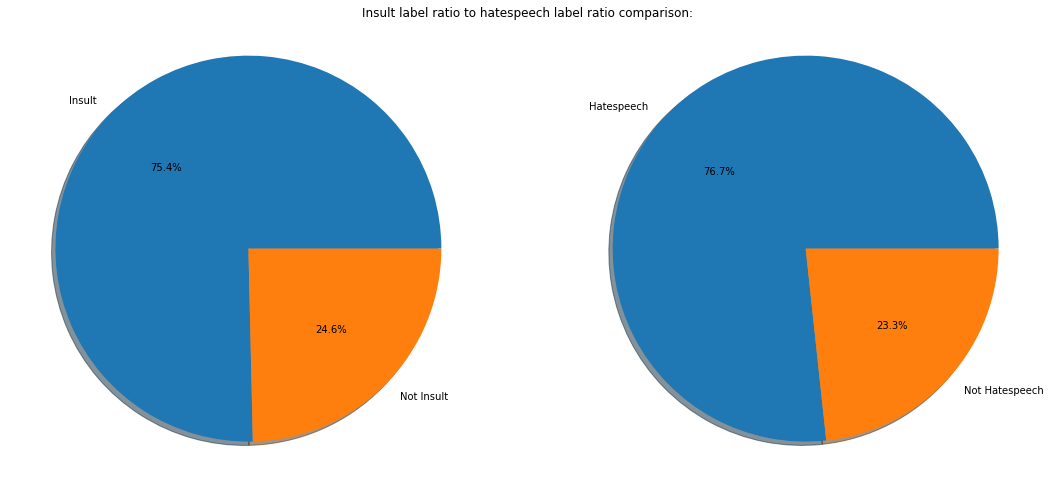

In [ ]:
import matplotlib.pyplot as plt
#define data
data = [len(combined_df[combined_df["Labels"] == 0])/len(combined_df),len(combined_df[combined_df["Labels"] == 1])/len(combined_df)]
data2 = [len(combined_df[combined_df["HS_Label"] == 0])/len(combined_df), len(combined_df[combined_df["HS_Label"] == 1])/len(combined_df)]
labels = ['Insult', 'Not Insult']
labels2 = ['Hatespeech', "Not Hatespeech"]

fig, ax = plt.subplots(1,2, figsize=(16,7))
ax[0].pie(data, labels=labels, autopct='%1.1f%%', shadow=True)
ax[1].pie(data2, labels=labels2, autopct='%1.1f%%', shadow=True)
plt.tight_layout()
fig.suptitle("Insult label ratio to hatespeech label ratio comparison:"); 

In [ ]:
def agreement_func():
    results = []
    for i in range(0, len(combined_df)):
        if combined_df["Labels"][i] == combined_df["HS_Label"][i]:
            results.append(True)
        else:
            results.append(False)
    return results

combined_df["Agreement"] = agreement_func()
combined_df

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bf1f20fb-a6c0-4ea2-8567-a5a41eea1d8a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>